In [45]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyBboxPatch

In [9]:
# Importing results.
data = "/results/yolov9e_640/Main/results.csv"

# Converting the string data to a pandas DataFrame.
df = pd.read_csv(data)

# Ensuring there are no hidden whitespace characters
df.columns = df.columns.str.strip()

df.head()

,epoch,train/box_loss,train/seg_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),metrics/precision(M),metrics/recall(M),metrics/mAP50(M),metrics/mAP50-95(M),val/box_loss,val/seg_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,2.4921,3.6063,2.7826,1.3213,0.23677,0.16631,0.10129,0.03961,0.23575,0.15879,0.09724,0.03397,2.5509,3.5560,2.2877,1.3450,0.067010,0.000333,0.000333
1,2,2.5302,3.5939,2.5009,1.3219,0.64292,0.11531,0.10789,0.04388,0.64062,0.10649,0.10060,0.03547,2.4724,3.5458,2.3571,1.3327,0.034003,0.000660,0.000660
2,3,2.5029,3.5629,2.4260,1.3068,0.17626,0.16787,0.11788,0.04844,0.17323,0.16435,0.11470,0.04380,2.4716,3.4904,2.2727,1.3191,0.000990,0.000980,0.000980
3,4,2.4694,3.4906,2.3162,1.2939,0.20031,0.17608,0.11345,0.04664,0.19424,0.16828,0.10683,0.03870,2.4825,3.5122,2.2598,1.3119,0.000970,0.000970,0.000970
4,5,2.4274,3.4419,2.2519,1.2880,0.17749,0.21320,0.12802,0.05222,0.17219,0.20035,0.11884,0.04200,2.4335,3.4394,2.1736,1.2953,0.000960,0.000960,0.000960


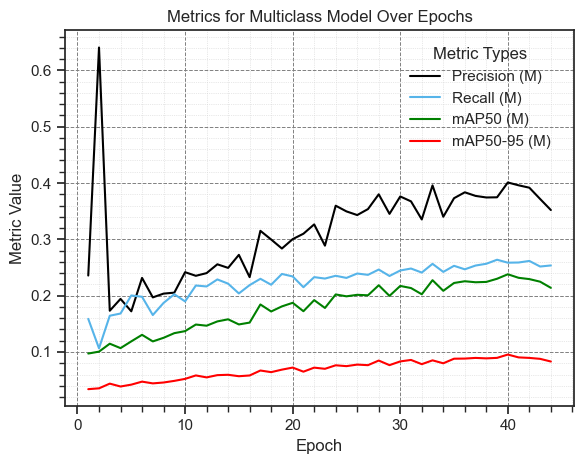

In [14]:
# Setting theme.
sns.set_theme(style = "ticks")

# Defining custom colour palette.
palette = ["black", "#56B4E9", "green", "red"]

# Melting the DataFrame for metrics(M).
metrics_melted = pd.melt(df,
                         id_vars = ["epoch"],
                         value_vars = ["metrics/precision(M)", "metrics/recall(M)", "metrics/mAP50(M)", "metrics/mAP50-95(M)"],
                         var_name = "metric_type",
                         value_name = "metric_value")

# Mapping the metric types to new names for the legend.
metric_type_mapping = {"metrics/precision(M)": "Precision (M)",
                       "metrics/recall(M)": "Recall (M)",
                       "metrics/mAP50(M)": "mAP50 (M)",
                       "metrics/mAP50-95(M)": "mAP50-95 (M)"}
metrics_melted["metric_type"] = metrics_melted["metric_type"].map(metric_type_mapping)

# Ploting the metrics.
plt.figure(figsize = (6, 4.8))

sns.lineplot(data = metrics_melted,
             x = "epoch", 
             y = "metric_value",
             hue = "metric_type",
             palette = palette)

# Setting plot titles and labels.
plt.title("Metrics for Multiclass Model Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")

# Adding gridlines.
plt.grid(visible = True, 
         which = "major", 
         color = "gray", 
         linestyle = "--", 
         linewidth = 0.7)

plt.grid(visible = True, 
         which = "minor", 
         color = "lightgray", 
         linestyle = ":", 
         linewidth = 0.5)

plt.minorticks_on()  

# Adjusting legend.
plt.legend(title = "Metric Types", 
           bbox_to_anchor = (0.65, 0.82), 
           loc = "center left", 
           frameon = False)

# Displaying.
plt.tight_layout()
plt.show()

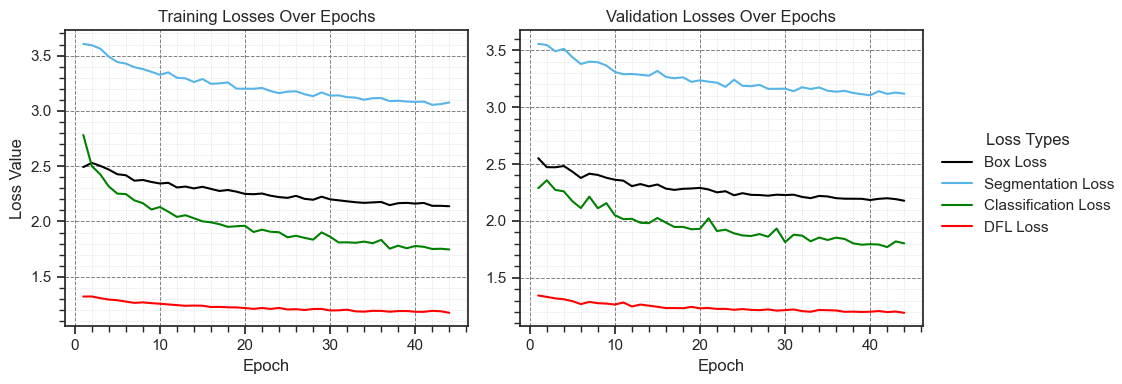

In [15]:
# Melting the DataFrame for training and validation losses.
loss_melted = pd.melt(df,
                      id_vars = ["epoch"],
                      value_vars = ["train/box_loss", "train/seg_loss", "train/cls_loss", "train/dfl_loss",
                                    "val/box_loss", "val/seg_loss", "val/cls_loss", "val/dfl_loss"],
                      var_name = "loss_type",
                      value_name = "loss_value")

# Adding column for dataset type (training or validation).
loss_melted["dataset_type"] = loss_melted["loss_type"].apply(lambda x: "Training" if "train" in x else "Validation")

# Remove prefixes for cleaner labels.
loss_melted["loss_type"] = loss_melted["loss_type"].apply(lambda x: x.split("/")[-1])

# Mapping the loss types to new names for the legend.
loss_type_mapping = {"box_loss": "Box Loss",
                     "seg_loss": "Segmentation Loss",
                     "cls_loss": "Classification Loss",
                     "dfl_loss": "DFL Loss"}
loss_melted["loss_type"] = loss_melted["loss_type"].map(loss_type_mapping)

# Plotting training and validation side by side.
g = sns.relplot(data = loss_melted,
                x = "epoch", 
                y = "loss_value",
                hue = "loss_type", 
                kind = "line",
                col = "dataset_type", 
                dashes = False,      
                palette = palette, 
                height = 4, 
                aspect = 1.2,
                facet_kws = dict(sharey = False, sharex = True))

# Setting titles and labels.
g.set_titles("{col_name} Losses Over Epochs")  # Using the column name.
g.set_axis_labels("Epoch", "Loss Value")

# Adjusting the legend title.
legend = g._legend
legend.set_title("Loss Types")
legend.set_bbox_to_anchor((0.81, 0.5))
legend.set_loc("center left")

# Ensuring the spines are visible.
for ax in g.axes.flat:
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)

    # Adding gridlines.
    ax.grid(visible = True, 
            which = "major", 
            color = "gray", 
            linestyle = "--", 
            linewidth = 0.7)
    
    ax.grid(visible = True, 
            which = "minor", 
            color = "lightgray", 
            linestyle = ":", 
            linewidth = 0.5)
    
    ax.minorticks_on() 

# Setting frame around the legend.
legend.get_frame().set_linewidth(1)
legend.get_frame().set_edgecolor("black")

# Displaying.
g.tight_layout()
plt.show()

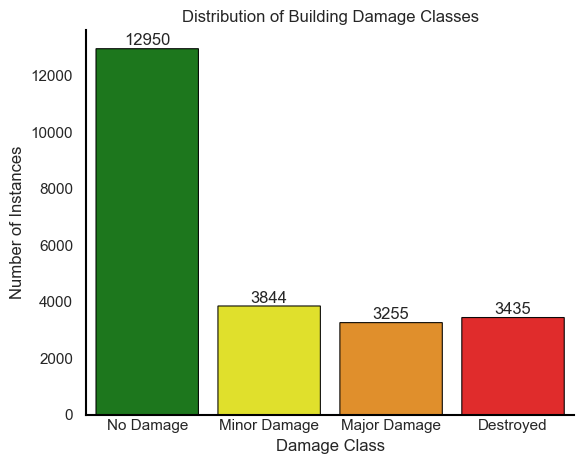

In [17]:
# Creating DataFrame for results.
data = {"Class": ["No Damage", "Minor Damage", "Major Damage", "Destroyed"],
        "Count": [12950, 3844, 3255, 3435]}
df = pd.DataFrame(data)

# Setting theme.
sns.set_theme(style = "whitegrid")

# Define colour palette.
palette = ["green", "yellow", "darkorange", "red"]

# Plotting barplot.
plt.figure(figsize = (6, 4.8))

bars = sns.barplot(data = df,
                   x = "Class", 
                   y = "Count",
                   hue = "Class",
                   palette = palette,
                   dodge = False,           # Ensuring bars are not split by hue.
                   edgecolor = "black",     # Adding edge colour to bars.
                   linewidth = 1.5,         # Thickness of bar edges.
                   alpha = 0.9,             # Transparency setting.
                   legend = False)

# Adding rounded edges.
for bar in bars.patches:
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    y = bar.get_y()

    # Removing the original bar.
    bar.set_visible(False)

    # Drawing rounded rectangle.
    plt.gca().add_patch(FancyBboxPatch((x, y), width, height,
                                       boxstyle="round,pad = 0.02, rounding_size = 0.1",  
                                       linewidth = 0.8,
                                       edgecolor = "black",
                                       facecolor = bar.get_facecolor(),
                                       alpha = 0.95))

# Setting titles and labels.
plt.title("Distribution of Building Damage Classes")
plt.xlabel("Damage Class")
plt.ylabel("Number of Instances")

# Removing horizontal gridlines.
plt.gca().yaxis.grid(False) 

# Removing vertical ticks and gridlines.
plt.gca().xaxis.grid(False) 
plt.gca().tick_params(axis = "x", 
                      which = "both", 
                      length = 0)  

# Adjusting spines.
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_edgecolor("black")
ax.spines["bottom"].set_edgecolor("black")
ax.spines["left"].set_linewidth(1.5)  
ax.spines["bottom"].set_linewidth(1.5) 

# Adding the count labels.
for i in range(len(df)):
    plt.text(i, df["Count"][i] + 10, str(df["Count"][i]), ha = "center", va = "bottom")

# Displaying.
plt.tight_layout()
plt.show()

no_damage: 40439.25 square meters, 81.20% of total
minor_damage: 4023.00 square meters, 8.08% of total
major_damage: 1392.57 square meters, 2.80% of total
destroyed: 3949.83 square meters, 7.93% of total


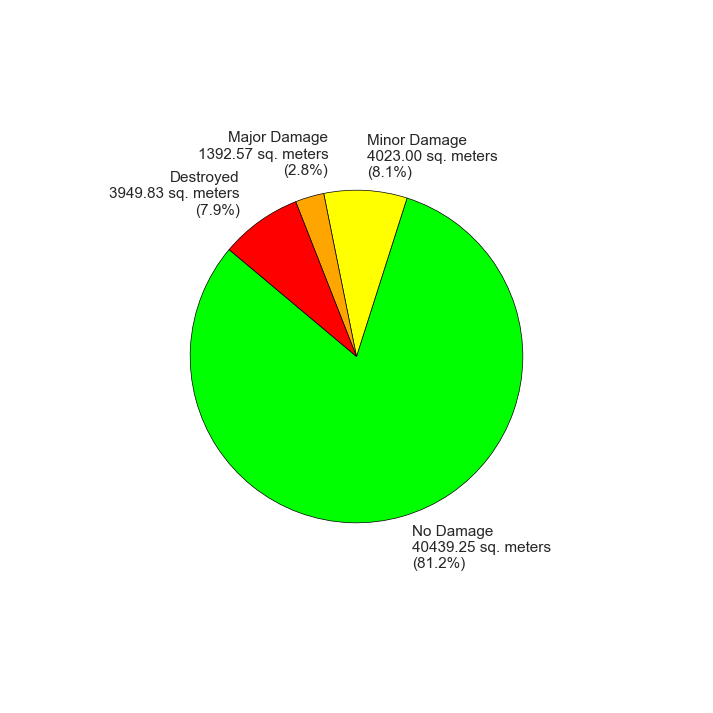

In [91]:
# Loading the predicted mask.
mask_image = cv2.imread("/reassembled_predicted_mask.png")

# Defining the colour mappings for each class.
class_colours = {"no_damage": (0, 255, 0),   # no-damage: green
                 "minor_damage": (255, 255, 0), # minor-damage: yellow
                 "major_damage": (255, 165, 0), # major-damage: orange
                 "destroyed": (255, 0, 0)}    # destroyed: red


# Creating dictionary to store the pixel counts.
pixel_counts = {"no_damage": 0,
                "minor_damage": 0,
                "major_damage": 0,
                "destroyed": 0}

# Converting mask image to RGB.
mask_image_rgb = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)

# Counting the pixels for each class.
for class_name, colour in class_colours.items():
    # Creating a binary mask where the pixels matching the colour are 1, and others are 0.
    class_mask = cv2.inRange(mask_image_rgb, np.array(colour), np.array(colour))
    # Counting non-zero pixels in the binary mask.
    pixel_counts[class_name] = cv2.countNonZero(class_mask)

# Setting the pixel size in meters.
pixel_size = 0.3

# Calculating the area for each class in square meters.
area_counts = {class_name: count * (pixel_size ** 2) for class_name, count in pixel_counts.items()}

# Calculating total area excluding the background.
total_area = sum(area_counts.values())

# Calculating the percentage of each class relative to the total area.
percentage_counts = {class_name: (area / total_area) * 100 for class_name, area in area_counts.items()}

# Printing the results.
for class_name in class_colours.keys():
    print(f"{class_name}: {area_counts[class_name]:.2f} square meters, {percentage_counts[class_name]:.2f}% of total")

# Preparing labels, sizes, and colours for the pie chart.
labels = list(area_counts.keys())
sizes = list(area_counts.values())
colours = [f'#{color[0]:02x}{color[1]:02x}{color[2]:02x}' for color in class_colours.values()]

# Setting theme.
sns.set_theme(style="whitegrid")

# Adjusting the labels to include square meters and percentage.
labels = [f"{class_name.replace('_', ' ').title()}\n{area:.2f} sq. meters\n({percentage:.1f}%)" 
          for class_name, area, percentage in zip(area_counts.keys(), area_counts.values(), percentage_counts.values())]

# Adjusting edge of pie.
edge_color = "black"  
line_width = 0.5 

# Creating the pie chart.
plt.figure(figsize = (9, 9))

patches, texts = plt.pie(sizes, 
                         labels = labels, 
                         colors = colours, 
                         startangle = 140, 
                         wedgeprops = {"edgecolor": edge_color, "linewidth": line_width},
                         radius = 0.6, 
                         labeldistance = 1.2)

# Adjust the position of "Major Damage".
for i, text in enumerate(texts):
    if "Major Damage" in text.get_text():
        x, y = text.get_position()
        x = x * 0.5 
        y = y * 1.055  
        text.set_position((x, y))
        text.set_fontsize(11) 

# Displaying the chart.
plt.show()